### **Environment**

In [27]:
import sys
print(sys.version)

3.10.12 (main, Nov 18 2024, 00:43:14) [Clang 14.0.3 (clang-1403.0.22.14.1)]


In [ ]:
import os
import shutil
import zipfile
import requests

import random
from PIL import Image
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

### **Dataset Description**

Flickr8k dataset is a popular dataset for image captioning tasks, the dataset consists of two primary parts:

- **Images**  
The dataset contains 8,092 images of various scenes, activities, and objects.  
These images are sourced from Flickr, covering diverse contexts such as people, animals, nature, and urban settings.
- **Captions**  
Each image has 5 associated captions.  
Captions are descriptive and written by humans, focusing on providing detailed information about the content and context of the image.

### **Download Dataset**

In [15]:
# Define paths and URLs
dataset_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
captions_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
dataset_dir = "flickr8k_dataset"
captions_file = "Flickr8k.token.txt"

# Create Dataset Directory
os.makedirs(dataset_dir, exist_ok=True)

# Download and Extract Functions
def download_file(url, dest_path):
    print(f"Downloading from {url}...")
    response = requests.get(url, stream=True)
    with open(dest_path, "wb") as file:
        shutil.copyfileobj(response.raw, file)
    print(f"File saved to {dest_path}")

def extract_zip(file_path, extract_to):
    print(f"Extracting {file_path}...")
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted to {extract_to}")

In [16]:
# Download images
images_zip_path = os.path.join(dataset_dir, "images.zip")
images_extract_path = os.path.join(dataset_dir, "Flicker8k_Dataset")

if not os.path.exists(images_extract_path):
    download_file(dataset_url, images_zip_path)
    extract_zip(os.path.join(dataset_dir, "images.zip"), dataset_dir)
else:
    print("Images already downloaded")

# Download captions
captions_txt_path = os.path.join(dataset_dir, captions_file)
if not os.path.exists(captions_txt_path):
    download_file(captions_url, os.path.join(dataset_dir, "captions.zip"))
    extract_zip(os.path.join(dataset_dir, "captions.zip"), dataset_dir)
else:
    print("Captions already downloaded")

Images already downloaded
Captions already downloaded


### **Raw Dataset**

A new dataset directory called *flickr8k_dataset* was created, the images were stored into Flickr8k_Dataset folder, each file name is unique in the format: imageID.jpg. Let's see some example


Total number of images 8091


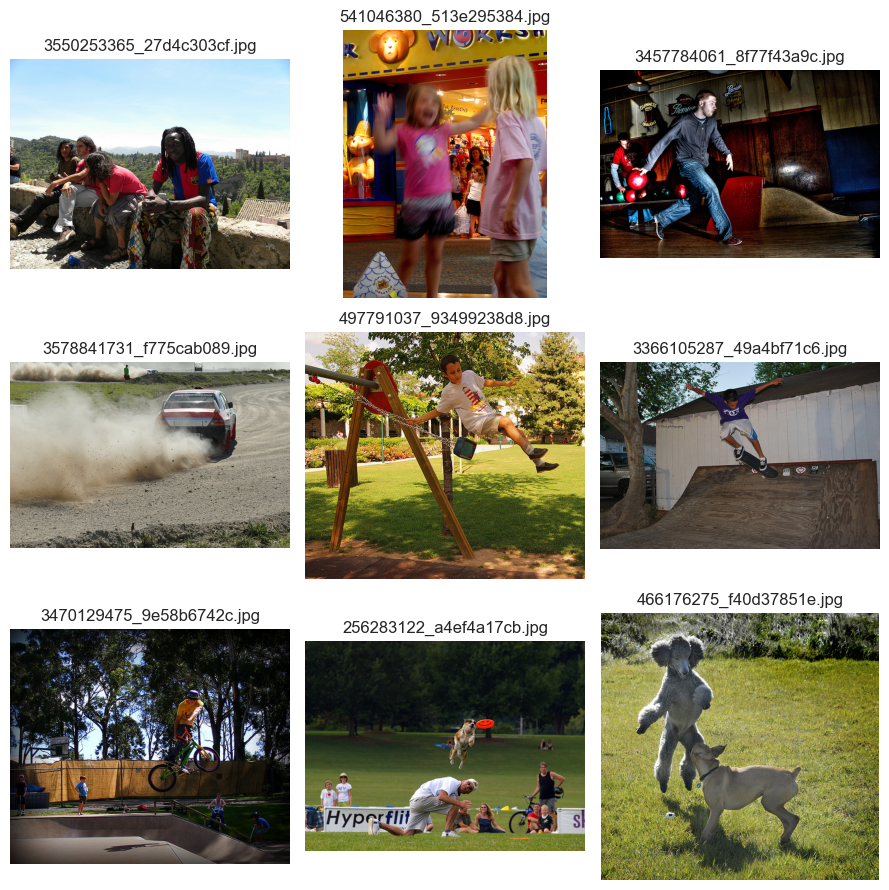

In [17]:
print("Total number of images",len(os.listdir(images_extract_path)))

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
random_images = random.sample(os.listdir(images_extract_path), 9)

for i, ax in enumerate(axes.flat):
    image_path = os.path.join(images_extract_path, random_images[i])
    image = Image.open(image_path)
    ax.imshow(image)
    ax.set_title(f"{random_images[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

On the other hand, captions are stored in the text file named *Flickr8k.token.txt*. The file contains image IDs and their corresponding captions in the following format: _ImageID#CaptionIndex\tCaptionText_. Each image ID is paired with five captions. Let's see an example


3303797949_339bb969ba.jpg#0	A boy wearing a shirt with an American flag plays with a basketball on the blacktop .
3303797949_339bb969ba.jpg#1	A boy with a basketball .
3303797949_339bb969ba.jpg#2	A young boy playing basketball .
3303797949_339bb969ba.jpg#3	Boy with american flag shirt bounces basketball .
3303797949_339bb969ba.jpg#4	The boy dribbles the ball in the playground .


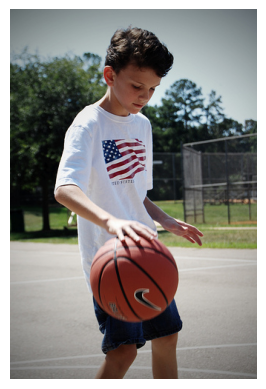

In [18]:
# Display captions
random_image_path = random.choice(os.listdir(images_extract_path))
with open(captions_txt_path, "r") as file:
    for caption in file.readlines():
        if random_image_path in caption:
            print(caption, end="")
plt.imshow(Image.open(os.path.join(images_extract_path, random_image_path)))
plt.axis("off")
plt.show()

As seen above, images have different size, let's break it down

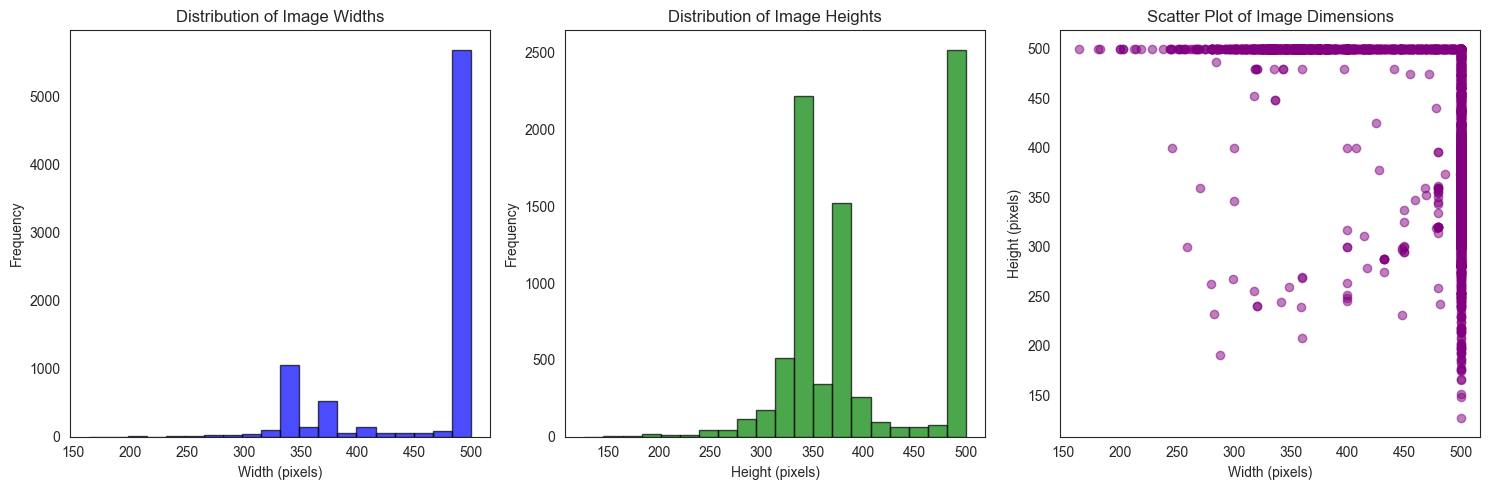

In [19]:
def analyze_image_sizes(images_path):
    widths = []
    heights = []

    # Extract image sizes
    for filename in os.listdir(images_path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(images_path, filename)
            with Image.open(image_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Width Distribution
    axs[0].hist(widths, bins=20, color='blue', alpha=0.7, edgecolor='black')
    axs[0].set_title("Distribution of Image Widths")
    axs[0].set_xlabel("Width (pixels)")
    axs[0].set_ylabel("Frequency")

    # Height Distribution
    axs[1].hist(heights, bins=20, color='green', alpha=0.7, edgecolor='black')
    axs[1].set_title("Distribution of Image Heights")
    axs[1].set_xlabel("Height (pixels)")
    axs[1].set_ylabel("Frequency")

    # Scatter Plot of Widths vs Heights
    axs[2].scatter(widths, heights, alpha=0.5, color='purple')
    axs[2].set_title("Scatter Plot of Image Dimensions")
    axs[2].set_xlabel("Width (pixels)")
    axs[2].set_ylabel("Height (pixels)")

    plt.tight_layout()
    plt.show()

analyze_image_sizes(images_extract_path)


Images in the Flickr8k dataset have been resized so that no dimension exceeds 500 pixels, likely as part of preprocessing or dataset preparation by the creators. If some images originally had high resolutions, resizing may result in the loss of small but important details and distort objects. On the countrary, smaller image sizes reduce computational and memory demands, making it feasible to train. It's a tradeoff.

### **Dataset Exploration**

Let's load the caption as a python dictionary

In [20]:
# Load Captions
captions_path = os.path.join(dataset_dir, captions_file)

def load_captions(filepath):
    captions = {}
    with open(filepath, 'r') as f:
        for line in f:
            image_id, caption = line.strip().split('\t')
            image_id = image_id.split('#')[0]
            if image_id not in captions:
                captions[image_id] = []
            captions[image_id].append(caption)
    return captions

captions_dictionary = load_captions(captions_path)

Now let's visualize some random image-captions pairs

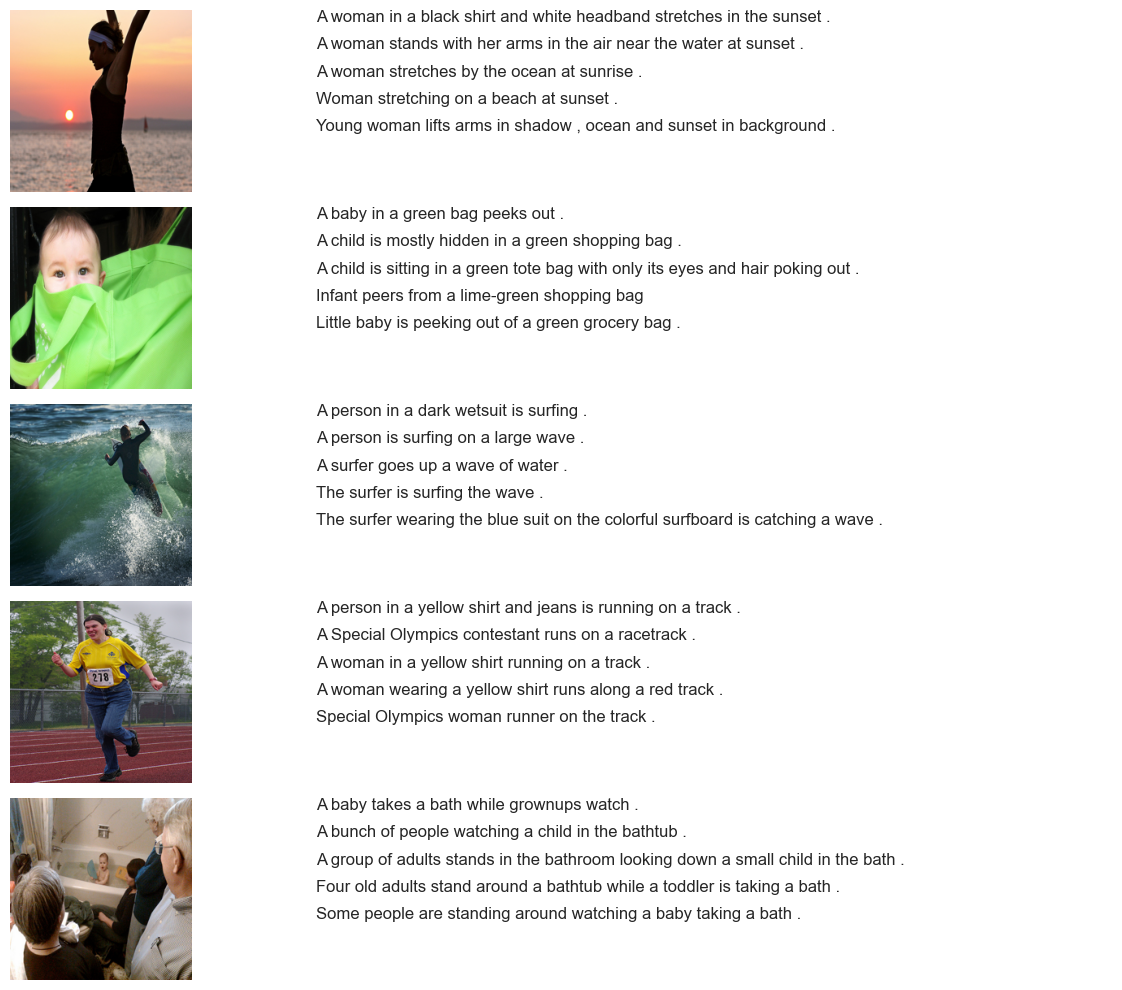

In [21]:
def visualization(captions_dictionary, images_path, num_of_images, image_size=(224, 224)):

    fig = plt.figure(figsize=(15, num_of_images * 2))
    count = 1
    
    #shuffle the dictionary
    shuffled_captions = dict(random.sample(list(captions_dictionary.items()), len(captions_dictionary)))
    
    for filename, captions in list(shuffled_captions.items())[:num_of_images]:
        image_path = os.path.join(images_path, filename)
        image_load = Image.open(image_path).resize(image_size)

        ax = fig.add_subplot(num_of_images, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        ax.axis("off") 
        count += 1

        ax = fig.add_subplot(num_of_images, 2, count)
        ax.axis("off") 
        for i, caption in enumerate(captions):
            ax.text(0, 1 - (i * 0.15), caption, fontsize=12, wrap=True, ha='left', va='top')
        count += 1
    
    plt.tight_layout()
    plt.show()

visualization(captions_dictionary, images_extract_path, 5, image_size=(224, 224))


### **Captions Exploration**

In [22]:
# Raw captions
captions = [caption for captions in captions_dictionary.values() for caption in captions]
captions[12:17]

['A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .',
 'A man lays on a bench while his dog sits by him .',
 'A man lays on the bench to which a white dog is also tied .']

First, let's clean the captions removing punctuation, numbers and whitespace using regular expressions

In [23]:
import re

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Cleaning
cleaned_captions = [clean_text(captions) for captions in captions]
cleaned_captions[12:17]

['A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'There is a girl with pigtails sitting in front of a rainbow painting',
 'Young girl with pigtails painting outside in the grass',
 'A man lays on a bench while his dog sits by him',
 'A man lays on the bench to which a white dog is also tied']

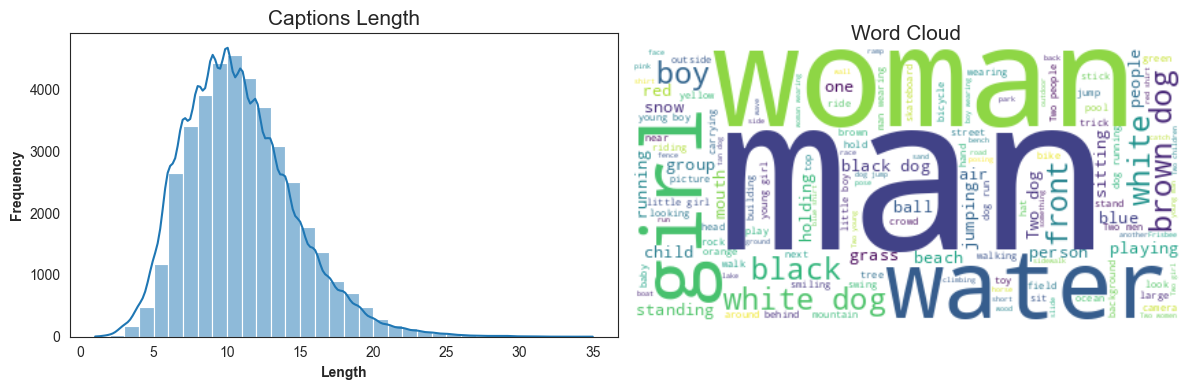

In [24]:
def captions_length(data):

    lengths = [len(x.split(' ')) for x in data]
    
    # Create the histogram plot
    sns.set_style('white')
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(x=lengths, kde=True, binwidth=1) 
    plt.title('Captions Length', fontsize=15)
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Frequency', fontweight='bold')
    
    # Create the word cloud
    wordcloud_text = ' '.join(data)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(wordcloud_text)
    
    # Plot the word cloud
    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud', fontsize=15)

    plt.tight_layout()
    plt.show()


captions_length(cleaned_captions)


Most captions have lengths between 5 and 15 words, the distribution peaks around 10 words, suggesting that captions in the Flickr8k dataset are concise and descriptive. As few captions exceed 20 words, we can expect the model be biased toward short and simple descriptions.

The most frequent words are "man," "woman," "dog," "boy," "girl," "water," "white," and "black". This suggests the dataset is focused on scenes involving people, animals, and common objects or environments (e.g., water, grass).

In [25]:
# Word Frequency
word_freq = {}
for caption in cleaned_captions:
    for word in caption.split():
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

# Sort the dictionary by frequency
word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))

In [26]:
def word_occurrences_combined(word_freq, word_freq2):
    # Extract data for both word frequency dictionaries
    data = [
        (list(word_freq.keys())[1:20], list(word_freq.values())[1:20], 'Top 20 Word Occurrences', 'rgba(30, 58, 138, {})'),
        (list(word_freq2.keys())[1:20], list(word_freq2.values())[1:20], 'Top 20 Word Occurrences (Excluding Stop Words)', 'rgba(91, 192, 222, {})')
    ]

    # Create a subplot figure
    fig = make_subplots(rows=1, cols=2, subplot_titles=[d[2] for d in data], specs=[[{'type': 'domain'}, {'type': 'domain'}]])

    # Add pie charts for both datasets
    for i, (words, values, _, color_template) in enumerate(data):
        normalized_values = np.array(values) / np.max(values)
        colors = ['rgba' + color_template.format(0.4 + 0.5 * value) for value in normalized_values]
        fig.add_trace(go.Pie(labels=words, values=values, hole=.6, marker=dict(colors=colors), textinfo='label'), row=1, col=i + 1)

    # Update and show the layout
    fig.update_layout(title="Word Frequency Comparisons", title_font=dict(size=23, family='Balto'), showlegend=False, height=600, width=1200)
    fig.show()

print("Total number of words:", len(word_freq))
word_freq2 = {k: v for k, v in word_freq.items() if k.lower() not in ['a', 'is', 'an', 'to', 'at', 'the', 'on', 'in', 'of', 'and', 'with']}
word_occurrences_combined(word_freq, word_freq2)


Total number of words: 9493


After excluding stop words, content-related words like "man," "woman," "dog," "black," "white," "two," "boy," and "girl" dominate. This reinforces the dataset's emphasis on scenes involving people, animals, and objects with attributes like colors or numbers.